In [2]:
# Installing Pillow Libraries
!pip install scikit-learn matplotlib Pillow


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score
from sklearn.model_selection import train_test_split

In [3]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

In [4]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list

In [84]:
dirpath = 'IIIT-CFW/'
X,y = load_data(dirpath)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


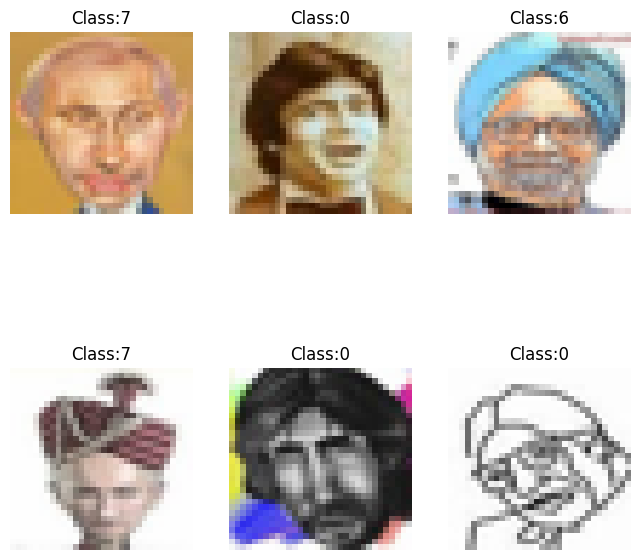

In [6]:
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

ind = np.random.randint(0,y.shape[0],6)
display_images(X[ind,...],y[ind], row=2,col=3)

# Part 1.1

In [142]:
class PCA:
    def __init__(self, data):
        self.data = data 
    
    def perform_pca(self):
        self.normalize_features()
        self.cov = np.cov(self.data, rowvar=False)
        self.get_eigen_values_vectors()
    
    def normalize_features(self):
        self.data = (self.data - np.mean(self.data,axis=0)) / np.std(self.data,axis=0)
    
    def get_eigen_values_vectors(self):
        # ChatGPT Prompt: How to find eigen vectors and eigen values from covariance matrix to perform PCA.
        self.eigenvalues, self.eigenvectors = np.linalg.eig(self.cov)

        # ChatGPT Prompt: How to sort both eigenvalues and eigenvectors by using argsort on eigenvalues.
        sorted_indices = np.argsort(self.eigenvalues)[::-1] 
        self.eigenvalues = self.eigenvalues[sorted_indices]
        self.eigenvectors = self.eigenvectors[:, sorted_indices]
        
    def reduced_data(self, num_features):
        selected_vectors = self.eigenvectors[:, :num_features]
        return np.real(np.dot(self.data, selected_vectors))
        
    def get_principal_component(self, pc_num):
        return self.eigenvectors[:, pc_num]
        
    def explained_variance(self, num):
        return np.real(self.eigenvalues[num]) / np.sum(np.real(self.eigenvalues))

In [92]:
X_flattenned = X.reshape(len(X), -1)

pca = PCA(X_flattenned)
pca.perform_pca()

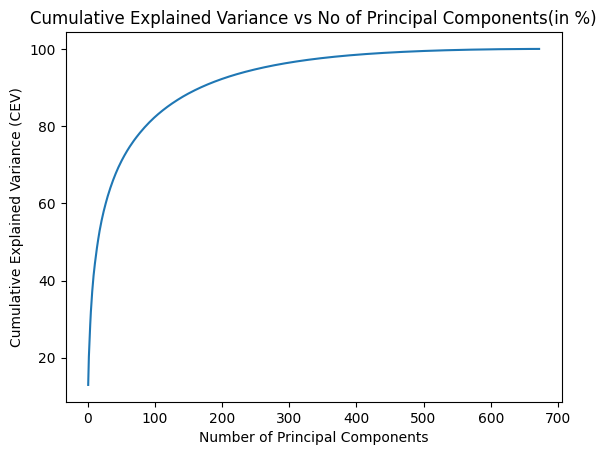

In [151]:
num_comps = []
exp_var = []

for i in range(1,len(X)+1):
    num_comps.append(i)
    exp_var.append(pca.explained_variance(i)) 

cev = np.cumsum(exp_var)
cev_normalized = cev / np.sum(exp_var)

plt.plot(num_comps, cev_normalized*100)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (CEV)')
plt.title('Cumulative Explained Variance vs No of Principal Components(in %)')
plt.show()

In [82]:
pictionary_data = np.load("data.npy",allow_pickle=True)

labels = pictionary_data[:,3]
ViT_features = np.vstack(pictionary_data[:,2])

kNN_pca = PCA(ViT_features)
kNN_pca.perform_pca()

ViT_final = kNN_pca.reduced_data(300)
X_train, X_test, Y_train, Y_test = train_test_split(ViT_final, labels, test_size=0.2)

(1500, 512)


In [150]:
kNN = KNeighborsClassifier(n_neighbors = 10, metric='euclidean')
kNN.fit(X_train,Y_train)
Y_pred = kNN.predict(X_test)

accuracy = accuracy_score(Y_test,Y_pred)
recall = recall_score(Y_test,Y_pred,average="weighted",zero_division=1)
f1score = f1_score(Y_test,Y_pred,average="weighted",zero_division=1)
precision = precision_score(Y_test,Y_pred,average="weighted",zero_division=1)

print("Accuracy Score: " + str(accuracy))
print("Recall Score: " + str(recall))
print("F-1 Score: " + str(f1score))
print("Precision: " + str(precision))

Accuracy Score: 0.4074074074074074
Recall Score: 0.4074074074074074
F-1 Score: 0.3846384714690246
Precision: 0.5255234900343019


# Observations:

1) PCA reduces the number of features in the dataset while retaining as much variance as possible. This can be particularly useful when we deal with high-dimensional data as in the case of Pictionary Dataset provided to us. Thus we observe that with fewer dimensions in the data generated after PCA, kNN calculations become comparatively quicker, as there are fewer features which have to be considered for generating the distances.

2) We see that for some hyperparameters, the kNN model on reduced data tends to perform better than the kNN model with the complete data with 512-dimensions(In case of ViT).

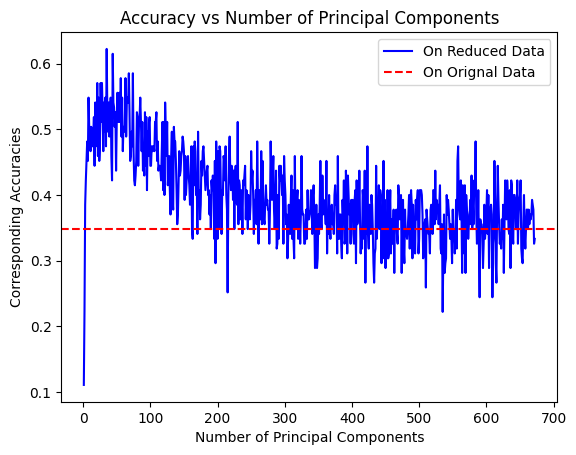

In [103]:
accuracies_normal = []
accuracies_pca = []
num_pcs = []

kNN_normal = KNeighborsClassifier(n_neighbors = 10, metric='euclidean')
X_train_normal, X_test_normal, Y_train_normal, Y_test_normal = train_test_split(X_flattenned, y, test_size=0.2)
kNN_normal.fit(X_train_normal,Y_train_normal)
Y_pred_normal = kNN_normal.predict(X_test_normal)

accuracy_normal = accuracy_score(Y_test_normal,Y_pred_normal)

for i in range(1,673):
    reduced_data = pca.reduced_data(i)
    kNN_pca = KNeighborsClassifier(n_neighbors = 10, metric='euclidean')
    X_train_pca, X_test_pca, Y_train_pca, Y_test_pca = train_test_split(reduced_data, y, test_size=0.2)
    kNN_pca.fit(X_train_pca,Y_train_pca)
    Y_pred_pca = kNN_pca.predict(X_test_pca)

    accuracy_pca = accuracy_score(Y_test_pca,Y_pred_pca)
    accuracies_pca.append(accuracy_pca)
    
    num_pcs.append(i)
    
plt.plot(num_pcs, accuracies_pca, color='b', label='On Reduced Data')
plt.axhline(y=accuracy_normal, color='red', linestyle='--', label='On Orignal Data')
plt.xlabel('Number of Principal Components')
plt.ylabel('Corresponding Accuracies')
plt.title('Accuracy vs Number of Principal Components')
plt.legend()
plt.show()

# Observations:

We observe that using PCA the model is able to generalize better as due to the increase in number of features the model would tend to overfit. Thus using PCA, with an optimal number of features we are able to get better accuracy results as compared to data with high dimensionality as is clear from the plot above.

# Part 1.2

In [137]:
df_drawer = np.asarray(pd.read_csv("./smai_assignment_pictionary/drawer_attributes.csv"))
df_guesser = np.asarray(pd.read_csv("./smai_assignment_pictionary/guesser_attributes.csv"))

In [143]:
drawer_pca = PCA(df_drawer)
guesser_pca = PCA(df_guesser)

drawer_pca.perform_pca()
guesser_pca.perform_pca()

In [144]:
drawer_pc1 = drawer_pca.reduced_data(1)
drawer_pc2 = drawer_pca.reduced_data(2)
drawer_pc3 = drawer_pca.reduced_data(3)

(100, 1)


Text(0.5, 1.0, 'Drawer PC1')

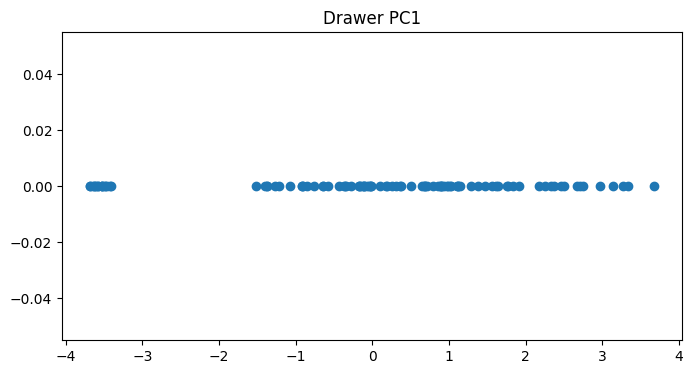

In [145]:
print(drawer_pc1.shape)
plt.figure(figsize=(8, 4))
plt.scatter(drawer_pc1, np.zeros_like(drawer_pc1))
plt.title('Drawer PC1')

Text(0.5, 1.0, 'Drawer PC1 vs PC2')

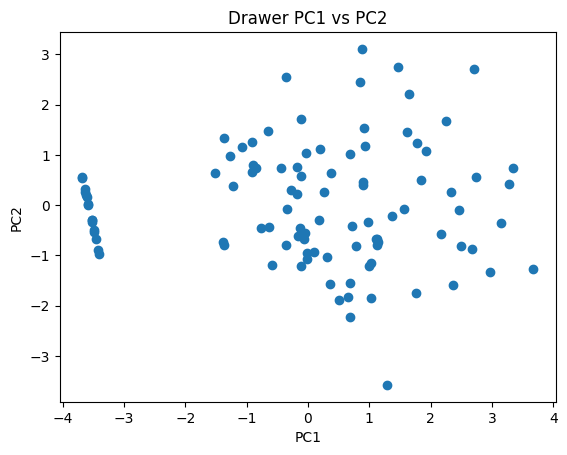

In [146]:
plt.scatter(drawer_pc2[:, 0],drawer_pc2[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Drawer PC1 vs PC2')

Text(0.5, 0.92, 'Drawer PC1 vs PC2 vs PC3')

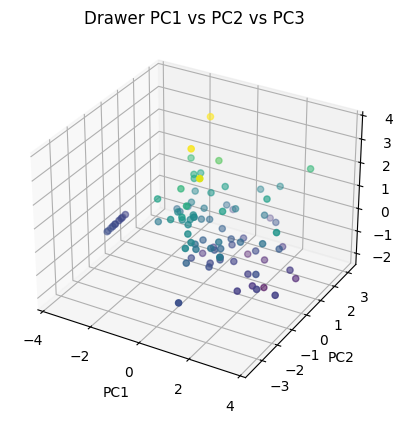

In [131]:
ax = plt.axes(projection='3d')

ax.scatter3D(drawer_pc3[:, 0], drawer_pc3[:, 1], drawer_pc3[:, 2], c=drawer_pc3[:, 2], cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Drawer PC1 vs PC2 vs PC3')

In [132]:
guesser_pc1 = guesser_pca.reduced_data(1)
guesser_pc2 = guesser_pca.reduced_data(2)
guesser_pc3 = guesser_pca.reduced_data(3)

Text(0.5, 1.0, 'Guesser PC1')

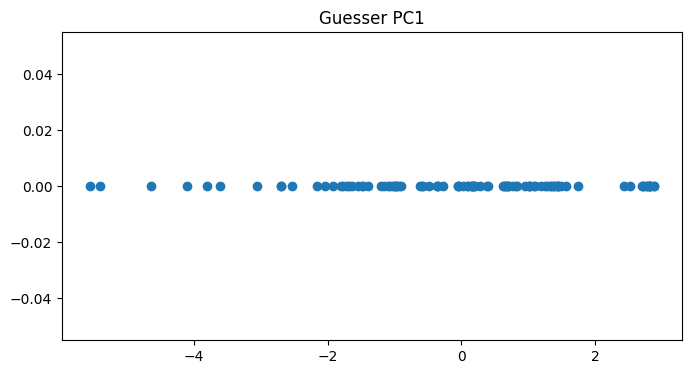

In [133]:
plt.figure(figsize=(8, 4))
plt.scatter(guesser_pc1, np.zeros_like(guesser_pc1))
plt.title('Guesser PC1')

Text(0.5, 1.0, 'Guesser PC1 vs PC2')

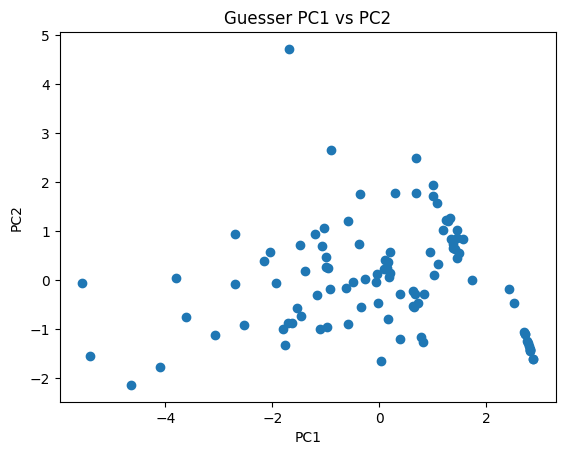

In [134]:
plt.scatter(guesser_pc2[:, 0], guesser_pc2[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Guesser PC1 vs PC2')

Text(0.5, 0.92, 'Guesser PC1 vs PC2 vs PC3')

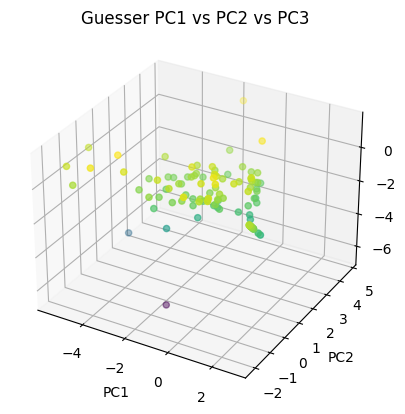

In [135]:
ax = plt.axes(projection='3d')

ax.scatter3D(guesser_pc3[:, 0], guesser_pc3[:, 1], guesser_pc3[:, 2], c=guesser_pc3[:, 2], cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Guesser PC1 vs PC2 vs PC3')

# Observation

1) After PCA, PC1 i.e. the first principal component captures the most variance of data and indicates the direction in the feature space along which the data varies the most.
 
2) PC2 captures the second most variance and is orthogonal to PC1. It is independent of PC1 and indicates the second-most important pattern or structure in the data.

3) As the Principal components increase, each subsequent features are captured in decreasing amounts of variance.